# Munich City

## Import

In [55]:
import sys
import os
import numpy as np
import pandas as pd
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import shape, box, LineString, MultiPolygon, Polygon, MultiPoint, Point, LinearRing
from shapely import wkt
# from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

# from wktplot import WKTPlot
# from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.__version__}")
print(f"Shapely GEOS version {shapely.geos_version_string}")
print(f"Shapely GEOS C API version {shapely.geos_capi_version_string}")

Py version 3.8.10
Shapely version 2.0.1
Shapely GEOS version 3.11.1
Shapely GEOS C API version 3.11.1-CAPI-1.17.1


In [700]:
pip install rasterio folium numpy contextily geopandas matplotlib

Exception ignored in: <function _after_fork at 0x7f53da8fa700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
    thread._stop()
TypeError: 'Event' object is not callable


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Functions

In [17]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the linearring geometry with requires at least 2 pairs of long, lat coordinates."""
#     coordinates = list(zip(long_array, lat_array))
#     ring_wkt = "LINEARRING(" + ", ".join(f"{x} {y}" for x, y in coordinates) + ")"
    ring_wkt = LinearRing(zip(long_array, lat_array))
    return ring_wkt
  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

        
def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygon Rings Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = wkt.loads(processPOLYGON(mainPOLYGON))
        
        linear_rings_array = []

        for ring in range(len(inputPOLYGON.interiors)):
            gridRING = processRING(inputPOLYGON.interiors[ring])
            linear_rings_array.append(gridRING)
            
        gridPOLYGON_WITH_HOLE_yx = Polygon(gridPOLYGON_yx.exterior, linear_rings_array)
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygons are Processed")
        
        return gridPOLYGON_WITH_HOLE_yx #return gridPOLYGON_yx_assembled
    
# def processPOLYGON_X(inputPOLYGON, regionID = None):
#     if len(inputPOLYGON.interiors) == 0:
#         polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
#         coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
#         expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
#         lat_arr = []
#         long_arr = []
#         for i in range(len(expected_list_of_coordinates_for_received_code)):
#             long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
#             lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

#         long_list = long_arr.tolist()
#         lat_list = lat_arr.tolist()

#         x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
#         gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

#         return gridPOLYGON_yx
#     else:
#         print(f"{regionID}: Polygon Ring Detected")
#         mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
#         gridPOLYGON_yx = wkt.loads(processPOLYGON_X(mainPOLYGON))
        
#         linear_rings_array = []

#         for ring in range(len(inputPOLYGON.interiors)):
#             gridRING = processRING(inputPOLYGON.interiors[ring])
#             linear_rings_array.append(gridRING)
            
#         gridPOLYGON_WITH_HOLE_yx = Polygon(gridPOLYGON_yx.exterior, linear_rings_array)
        
#         return gridPOLYGON_WITH_HOLE_yx #return gridPOLYGON_yx_assembled
           

######## Mother Function ##############################################################################################
########################################################################################

def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(unary_union(gridMULTI))

    
    
    
         

           
          
        
def breakMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        return str("")
    else:
        for polygon in multipolygon.geoms:
            polygons_array.append(polygon)

#     print("# of internal polygons is ",len(polygons_array))
    return polygons_array

def repairMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        print("Flag 1")
        return str("")
    else:
        print("Flag 2")
        for polygon in multipolygon.geoms:
            polygon = wkt.loads(add_closing_coordinates(str(polygon)))
            polygons_array.append(polygon)
    print("Flag 3")
    return unary_union(polygons_array)

def checkMULTIPOLYGONS(df,col_name):
   """checks if a vector data has multipolygons"""
   df = df.assign(isMULTI=df['geometry'].apply(lambda row :len(breakMULTIPOLYGONS(wkt.loads(str(row))))))
   df_multipolygons = df[df['isMULTI'] > 0]
   view = pd.DataFrame({'Districts':df_multipolygons[str(col_name)],'MultiPolygons':df_multipolygons['isMULTI']})
   return view


######## RasDaMan F(X) ##############################################################################################
################################################################################################################

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == (fill_val)] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap(data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis (Longitude)')
    plt.ylabel('y-axis (Latitude)')
    # Displaying the plot
    plt.show()
    return True #return numpy_array   

def query2array(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
    
def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    return result

def query2tiff(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
  
def checkRASTER(RASTER_NAME, FILL = 50.0):
    dimension = query2result('select sdom(datacube) from '+str(RASTER_NAME)+' as datacube')
    q_ansi_upper = 'select sdom(t)[0].hi from '+str(RASTER_NAME)+' as t'
    q_lat_upper = 'select sdom(y)[1].hi from '+str(RASTER_NAME)+' as y'
    q_long_upper = 'select sdom(x)[2].hi from '+str(RASTER_NAME)+' as x'
    
    gridTime = int("{}".format(query2result(q_ansi_upper)))+1;  # index start from 0 in rasdaman so +1
    gridLat = int("{}".format(query2result(q_lat_upper)))+1;
    gridLong = int("{}".format(query2result(q_long_upper)))+1;
    
    Time = []
    TOTAL = []
    VALID = []
    RATIO = []
    print("Entering the time loop \n")
    for t in range(0, gridTime):
        q = 'select (raster['+str(t)+', 0:* , 0:*]*0.02)-273.15 from '+str(RASTER_NAME)+' as raster' 
        array = query2array(q)
        if np.count_nonzero(array)*100/array.size >= FILL:   # Threshold parcentage of valid pixels
            Time = np.append(Time, t)
            TOTAL = np.append(TOTAL, array.size)
            VALID = np.append(VALID, np.count_nonzero(array))
            RATIO = np.append(RATIO, np.count_nonzero(array)*100/array.size)
            print(f"Time = {t}, \t VALID = {np.count_nonzero(array)} / {array.size},\t\t Coverage(%) = {'{:.2f}'.format(np.count_nonzero(array)*100/array.size)}")
    
    
    fig = plt.figure(figsize = (16, 5))
    # creating the bar plot
    bar = plt.bar(Time, RATIO, color ='maroon', width = 1)
    # Add counts above the two bar graphs
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

    plt.xlabel("Temporal Snaps")
    plt.ylabel("Valid / Total")
    plt.title(f"Raster Name: {RASTER_NAME}")
    plt.show()

## Vector Data

In [18]:
gdfDist25 = gpd.read_file('/home/arkaghosh/Downloads/MunichCity/VectorData/Munich_25_Bezirke_Dissolved.shp')
gdfSubDist105 = gpd.read_file('/home/arkaghosh/Downloads/MunichCity/VectorData/Munich_105_Bezirke.shp')

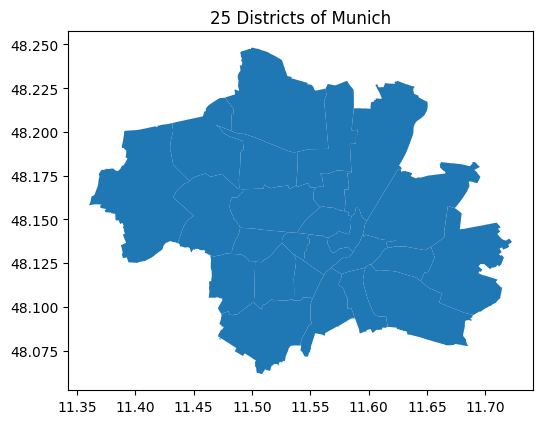

In [19]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfDist25.plot(ax=ax1)
ax1.set(title="25 Districts of Munich")
plt.show()

In [20]:
gdfDist25.head()

,Nr,FIRST_Bezi,FIRST_Nr,geometry
0,1,Altstadt-Lehel,1,"POLYGON ((11.59520 48.14170, 11.59500 48.14120..."
1,2,Ludwigsvorstadt-Isarvorstadt,2,"POLYGON ((11.55600 48.14080, 11.55930 48.14060..."
2,3,Maxvorstadt,3,"POLYGON ((11.58430 48.14420, 11.58310 48.14140..."
3,4,Schwabing-West,4,"POLYGON ((11.58170 48.17630, 11.58320 48.16940..."
4,5,Au-Haidhausen,5,"POLYGON ((11.59560 48.14050, 11.59590 48.14030..."


Laim


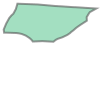

In [21]:
gid = 24 # 0 to 24
print(gdfDist25.FIRST_Bezi[gid])
INPUT = gdfDist25.geometry[gid]
INPUT

In [22]:
INPUT.area

0.0006245799999999138

In [787]:
gridPOLYGON = processPOLYGON(INPUT)
gridPOLYGON

'POLYGON ((375 548, 376 569, 376 571, 379 611, 382 605, 386 599, 389 597, 395 593, 401 594, 409 583, 414 574, 419 569, 423 564, 425 562, 428 558, 430 554, 432 548, 435 539, 437 535, 441 531, 440 511, 440 502, 440 493, 437 490, 434 487, 429 480, 426 472, 425 468, 425 462, 424 443, 424 439, 418 439, 407 443, 400 447, 396 449, 392 453, 389 457, 384 459, 380 461, 374 463, 370 464, 371 502, 374 535, 375 548))'

In [ ]:
gridPOLYGON

In [9]:
gridRING = processRING(INPUT.interiors)
gridRING

AttributeError: 'InteriorRingSequence' object has no attribute 'is_closed'

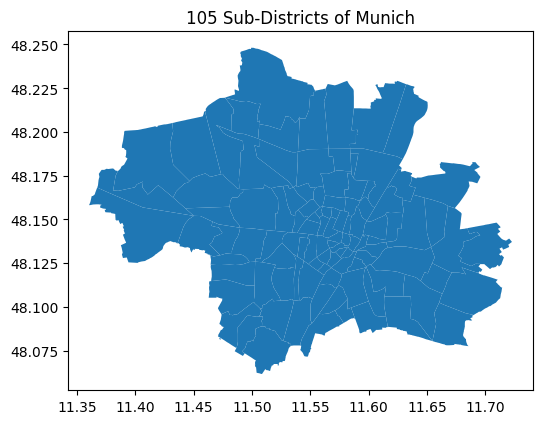

In [10]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfSubDist105.plot(ax=ax1)
ax1.set(title="105 Sub-Districts of Munich")
plt.show()

In [737]:
gdfSubDist105

,NAME,Bezirk,Nr,geometry
0,Herzogpark,Bogenhausen,13,"POLYGON ((11.59860 48.14920, 11.60530 48.15670..."
1,Daglfing,Bogenhausen,13,"POLYGON ((11.64760 48.16240, 11.65490 48.16110..."
2,Harlaching,Untergiesing-Harlaching,18,"POLYGON ((11.54150 48.07530, 11.54160 48.07560..."
3,Alte Heide - Hirschau,Schwabing-Freimann,12,"POLYGON ((11.58420 48.19040, 11.58450 48.19040..."
4,Steinhausen,Au-Haidhausen,5,"POLYGON ((11.59790 48.13560, 11.59830 48.13710..."
...,...,...,...,...
100,Thalkirchen,Thalkirchen-Obersendling-Forstenried-Fürstenri...,19,"POLYGON ((11.52690 48.08050, 11.53020 48.08850..."
101,Alt Moosach,Moosach,10,"POLYGON ((11.53880 48.17650, 11.53800 48.16950..."
102,Moosach-Bahnhof,Moosach,10,"POLYGON ((11.46940 48.20360, 11.46960 48.20390..."
103,Königsplatz,Maxvorstadt,3,"POLYGON ((11.56760 48.15150, 11.57280 48.15010..."


St. Ulrich of Laim


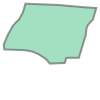

In [12]:
gid = 24
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

Friedenheim of Laim


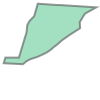

In [13]:
gid = 54 
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

## Raster Data

In [23]:
raster01_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/SRTMGL1_NC.003_30m_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/MOD11A1.061_1km_aid0001.nc'

In [24]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
dem = f['SRTMGL1_DEM'].values

In [25]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())
ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [26]:
xmin, xmax, ymin, ymax

(11.360833333342422, 11.723055555564933, 48.06166666670512, 48.248055555594156)

In [27]:
pixel_size = 0.0002777777777779992 #0.00833333333258679

## RasDaMan

In [28]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

RasDaMan is running


In [29]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
collection_list = list(collection_list)
collection_list

['Munich_Temperature_MODIS_1km',
 'South_Tyrol_Temperature_MODIS_1km',
 'Bavaria_NDVI_250m',
 'LST_03_GeoTIFF_FLIPPED',
 'Munich_SRTM_NC_Elevation',
 'LST_03_GeoTIFF_FLIPPED_CRS',
 'Winter_in_sweden1',
 'Munich_MODIS_NDVI',
 'Bavaria_Temperature_MODIS_1km',
 'AIR_TEMP_X',
 'Surface_Temperature_Sweden']

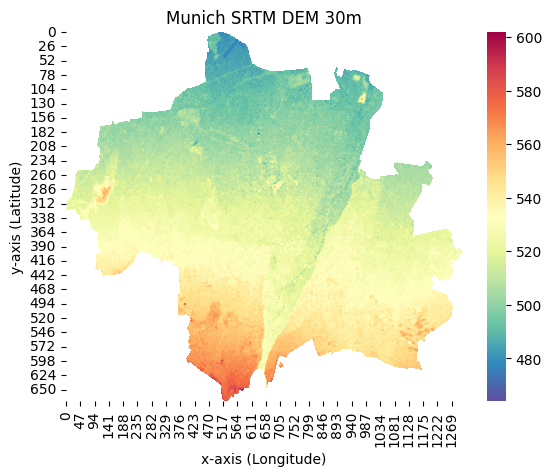

True

In [12]:
q = "select datacube[0, 0:* , 0:*] from Munich_SRTM_NC_Elevation as datacube" #100, 178
query2array2visuallize(q, "Munich SRTM DEM 30m", -32768) # FILL VAL = -32768 (from gdalinfo)

[0:1028,0:22,0:43]
1028
22
43
Entering the time loop 

Time = 0, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 13, 	 VALID = 623 / 1012,		 Coverage(%) = 61.56
Time = 17, 	 VALID = 620 / 1012,		 Coverage(%) = 61.26
Time = 35, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 38, 	 VALID = 621 / 1012,		 Coverage(%) = 61.36
Time = 39, 	 VALID = 624 / 1012,		 Coverage(%) = 61.66
Time = 43, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 49, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 56, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 57, 	 VALID = 625 / 1012,		 Coverage(%) = 61.76
Time = 58, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 61, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 62, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 65, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 67, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 68, 	 VALID = 624 / 1012,		 Coverage(%) = 61.66
Time = 77, 	 VALID = 624 / 1012,		 Coverage(%) = 61.66
Time = 79, 

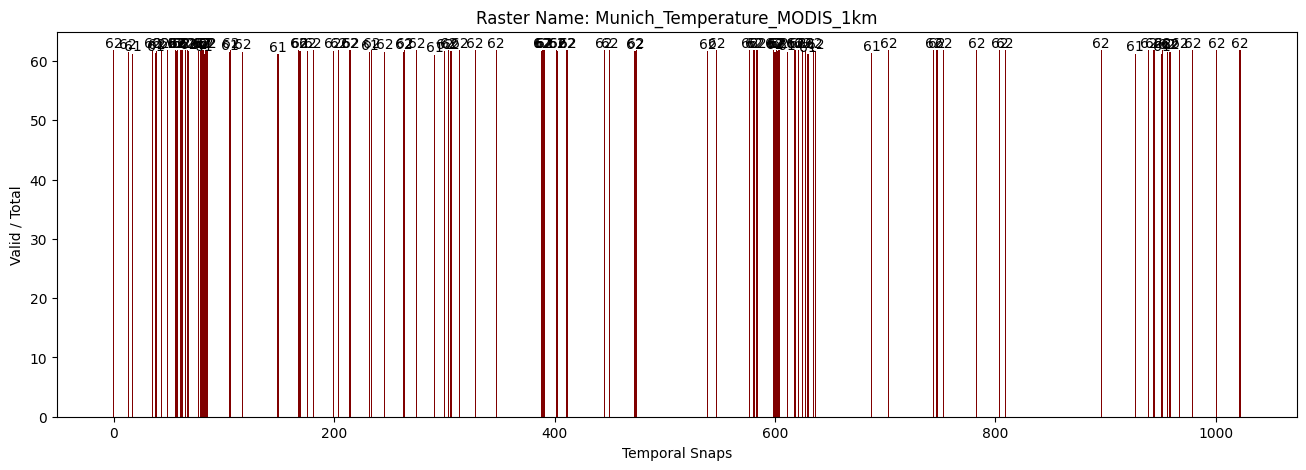

In [22]:
checkRASTER('Munich_Temperature_MODIS_1km', 61) #51% confidense

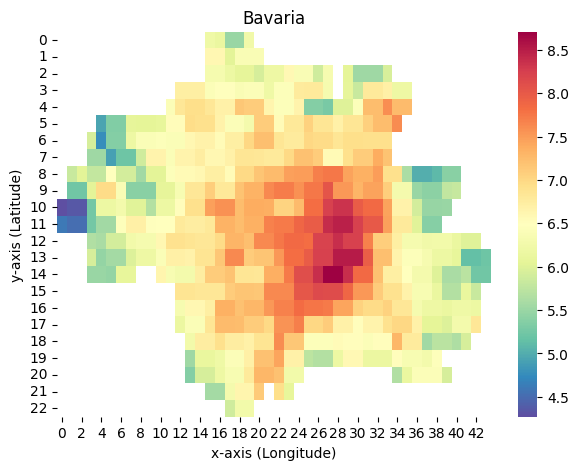

True

In [23]:
q = "select (mr[1022, 0:* , 0:*]*0.02)-273.15 from Munich_Temperature_MODIS_1km as mr" #100, 178
query2array2visuallize(q, "Bavaria", 0)

# Integration

## Laim

Laim


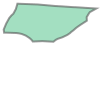

In [24]:
gid = 24 # 0 to 24
print(gdfDist25.FIRST_Bezi[gid])
INPUT = gdfDist25.geometry[gid]
INPUT

In [25]:
qAGGREGATE= 'select avg_cells(clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Munich_SRTM_NC_Elevation as m'
query2numeric(qAGGREGATE)

24: Polygon is processing


531.3272661523625

24: Polygon is processing


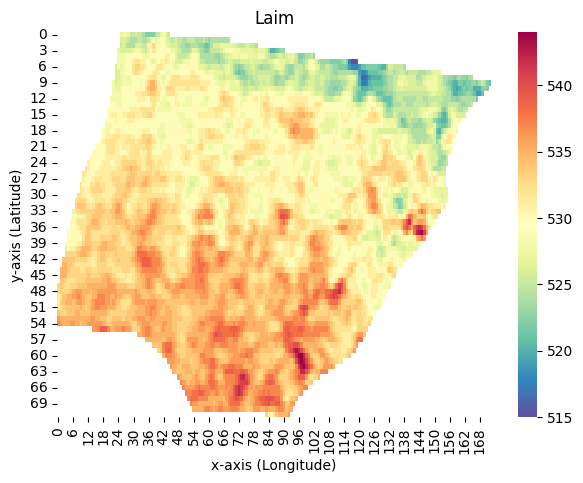

True

In [26]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfDist25.FIRST_Bezi[gid]), -32768)

In [31]:
# qARRAY1= 'select clip(m[1022, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_Temperature_MODIS_1km as m'
# query2array2visuallize(qARRAY1, str(gdfDist25.FIRST_Bezi[gid]), 0)

## St. Ulrich

St. Ulrich of Laim


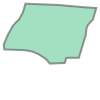

In [32]:
gid = 24
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [33]:
qAGGREGATE= 'select avg_cells(clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Munich_SRTM_NC_Elevation as m'
query2numeric(qAGGREGATE)

24: Polygon is processing


531.9526964844468

24: Polygon is processing


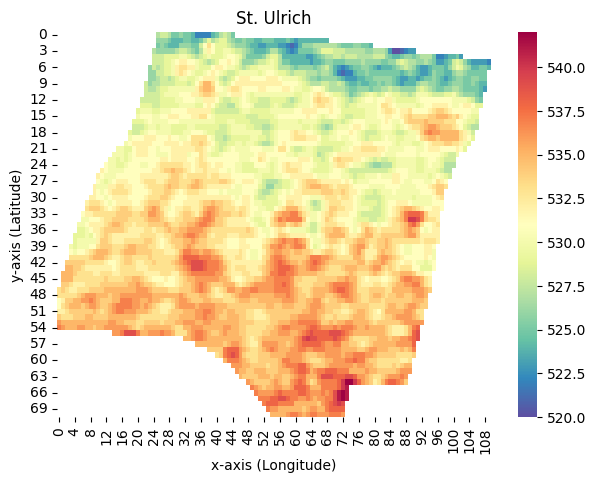

True

In [34]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), -32768)

In [37]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_Temperature_MODIS_1km as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), 0)

24: Polygon is processing


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "FError: All polygons in the request lie outside the MDDObject's domain. "
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:7002 {created_time:"2024-12-14T23:47:00.104758087+07:00", grpc_status:2, grpc_message:"\x08\x8a\x04\x10\x01\x1a\x46\x45rror: All polygons in the request lie outside the MDDObject\'s domain. \x01"}"
>

## Friedenheim

Friedenheim of Laim


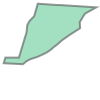

In [79]:
gid = 54
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [229]:
qAGGREGATE= 'select avg_cells(clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Munich_SRTM_NC_Elevation as m'
query2numeric(qAGGREGATE)

54: Polygon is processing


530.2118845500848

54: Polygon is processing


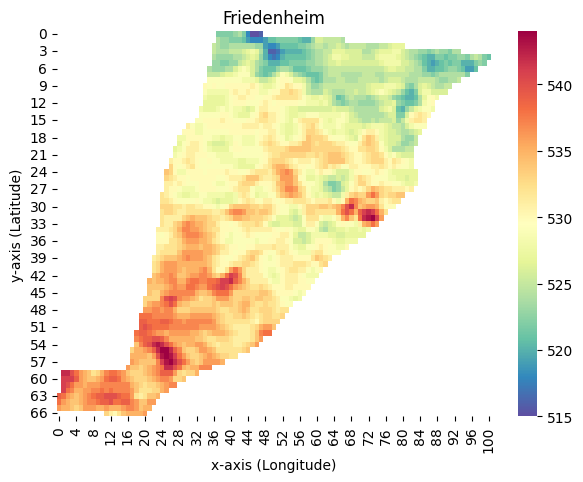

True

In [230]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), -32768)

In [39]:
# qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_Temperature_MODIS_1km as m'
# query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), 0)

# ----------------------------------------------------------------------------------------------

In [ ]:
import os    
from osgeo import gdal, osr, ogr # Python bindings for 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from shapely import Point, Polygon, bounds, wkt
# import rasterio
from rasterio.plot import show, reshape_as_image, reshape_as_raster, reshape_as_image
# import folium
from folium.raster_layers import ImageOverlay

# query2geoTIFF ()

- https://geonetcast.wordpress.com/2022/05/12/creating-a-geotiff-from-a-numpy-array/
- https://wiki.openstreetmap.org/wiki/Bounding_box
- http://bboxfinder.com

54: Polygon is processing


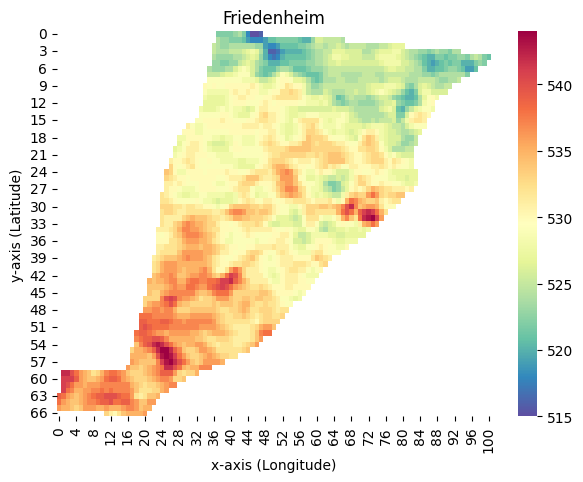

True

In [50]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), -32768)

In [63]:
OUTPUT = query2tiff(qARRAY, -32768)
OUTPUT

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan, 522., 522., 522., 522., 523., 524., 522.,
        518., 515., 515., 516.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan, 524., 523., 523., 522., 522., 522., 521.,
        519., 518

In [58]:
# Create a test 2D array (randon numbers between 0 and 9)
# nlines = 30
# ncolumns = 30
# data = np.random.randint(0, 100, size=(nlines,ncolumns))

In [60]:
#---------------------------------------------------------------------------------------------------------------------------
# Required modules
# from osgeo import gdal, osr, ogr # Python bindings for GDAL
#---------------------------------------------------------------------------------------------------------------------------
 
def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [-93.0, -60.00, -25.00, 18.00] # South America
 
# Export the test array to GeoTIFF ================================================
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
 
# Get dimensions
nlines = data.shape[0]
ncols = data.shape[1]
nbands = len(data.shape)
data_type = gdal.GDT_Int16 # gdal.GDT_Float32
 
# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nlines, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)
 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(data)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
 
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
file_name = 'my_test_data02.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  
 
# Close the file
driver = None
grid_data = None
 
# Delete the temp grid    
# import os    
os.remove('grid_data')


Generated GeoTIFF: my_test_data02.tif


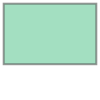

In [87]:
shapely.envelope(INPUT)

In [91]:
print(shapely.envelope(INPUT))

POLYGON ((11.5028 48.1255, 11.5308 48.1255, 11.5308 48.1438, 11.5028 48.1438, 11.5028 48.1255))


In [89]:
shapely.bounds(INPUT).tolist()

[11.5028, 48.1255, 11.5308, 48.1438]

In [95]:
extent = [11.5028, 48.1255, 11.5308, 48.1438] # South America
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
# Get dimensions
nrows = OUTPUT.shape[0]
ncols = OUTPUT.shape[1]
nbands = len(OUTPUT.shape)
data_type = gdal.GDT_Float32

In [96]:
nrows, ncols, nbands, data_type

(67, 101, 2, 6)

In [97]:
# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)
 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(OUTPUT)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
 
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))
 
# Save the file
file_name = 'Friedenheim02.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  
 
# Close the file
driver = None
grid_data = None
 
# Delete the temp grid
import os                
os.remove('grid_data')


Generated GeoTIFF: Friedenheim02.tif


## Biederstein

In [725]:
gid = 56
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
print(INPUT)

Biederstein of Schwabing-Freimann
POLYGON ((11.5926 48.1603, 11.5929 48.1608, 11.5937 48.162, 11.595 48.164, 11.595 48.1641, 11.5958 48.1653, 11.5979 48.1694, 11.5985 48.1706, 11.5986 48.1707, 11.5995 48.172, 11.604 48.17189999999999, 11.6053 48.1718, 11.6048 48.1708, 11.6052 48.1701, 11.6062 48.17, 11.6063 48.1692, 11.6058 48.16889999999999, 11.6046 48.1685, 11.6034 48.1676, 11.6021 48.1661, 11.6011 48.1655, 11.6005 48.1647, 11.5999 48.164, 11.5997 48.1636, 11.6 48.163, 11.6002 48.1625, 11.6001 48.16220000000001, 11.5998 48.162, 11.5995 48.1619, 11.5991 48.1619, 11.5973 48.1629, 11.5972 48.1629, 11.5966 48.1628, 11.5963 48.16269999999999, 11.5948 48.1618, 11.5942 48.1614, 11.5934 48.1606, 11.593 48.1605, 11.5926 48.1603))


In [729]:
poly = 'POLYGON ((11.5926 48.1603, 11.5929 48.1608, 11.5937 48.162, 11.595 48.164, 11.595 48.1641, 11.5958 48.1653, 11.5979 48.1694, 11.5985 48.1706, 11.5986 48.1707, 11.5995 48.172, 11.604 48.17189999999999, 11.6053 48.1718, 11.6048 48.1708, 11.6052 48.1701, 11.6062 48.17, 11.6063 48.1692, 11.6058 48.16889999999999, 11.6046 48.1685, 11.6034 48.1676, 11.6021 48.1661, 11.6011 48.1655, 11.6005 48.1647, 11.5999 48.164, 11.5997 48.1636, 11.6 48.163, 11.6002 48.1625, 11.6001 48.16220000000001, 11.5998 48.162, 11.5995 48.1619, 11.5991 48.1619, 11.5973 48.1629, 11.5972 48.1629, 11.5966 48.1628, 11.5963 48.16269999999999, 11.5948 48.1618, 11.5942 48.1614, 11.5934 48.1606, 11.593 48.1605, 11.5926 48.1603))'

In [731]:
poly = wkt.loads('POLYGON ((11.5926 48.1603, 11.5929 48.1608, 11.5937 48.162, 11.595 48.164, 11.595 48.1641, 11.5958 48.1653, 11.5979 48.1694, 11.5985 48.1706, 11.5986 48.1707, 11.5995 48.172, 11.604 48.17189999999999, 11.6053 48.1718, 11.6048 48.1708, 11.6052 48.1701, 11.6062 48.17, 11.6063 48.1692, 11.6058 48.16889999999999, 11.6046 48.1685, 11.6034 48.1676, 11.6021 48.1661, 11.6011 48.1655, 11.6005 48.1647, 11.5999 48.164, 11.5997 48.1636, 11.6 48.163, 11.6002 48.1625, 11.6001 48.16220000000001, 11.5998 48.162, 11.5995 48.1619, 11.5991 48.1619, 11.5973 48.1629, 11.5972 48.1629, 11.5966 48.1628, 11.5963 48.16269999999999, 11.5948 48.1618, 11.5942 48.1614, 11.5934 48.1606, 11.593 48.1605, 11.5926 48.1603))')
type(poly)

shapely.geometry.polygon.Polygon

In [732]:
shapely.bounds(poly).tolist()

[11.5926, 48.1603, 11.6063, 48.172]

In [113]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
# query2array(qARRAY, -32768)

56: Polygon is processing


In [132]:
import os   
from osgeo import gdal, osr, ogr # Python bindings for GDAL
from shapely import bounds

def query2tiff(query, INPUT, filename = None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
    
    driver = gdal.GetDriverByName('GTiff')  # Get GDAL driver GeoTiff
    extent = shapely.bounds(INPUT).tolist()
    # Get dimensions
    nrows = numpy_array.shape[0]
    ncols = numpy_array.shape[1]
    nbands = len(numpy_array.shape)
    data_type = gdal.GDT_Float32
    # Create a temp grid
    #options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
    grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(numpy_array)

    # Lat/Lon WSG84 Spatial Reference System
    srs = osr.SpatialReference()
    srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))

    # Save the file
    file_name = str(filename)+'.tif'
    print(f'Generated GeoTIFF: {file_name}')
    driver.CreateCopy(file_name, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid            
    os.remove('grid_data')

In [117]:
query2tiff(qARRAY, INPUT, -32768)

Generated GeoTIFF: Friedenheim03.tif


## Thalkirchen

Industriebezirk of Allach-Untermenzing


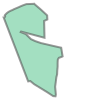

In [230]:
gid = 10
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [134]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'

10: Polygon is processing


In [135]:
query2tiff(qARRAY, INPUT, 'Industriebezirk', -32768)

Generated GeoTIFF: Industriebezirk.tif


# query2osm ()

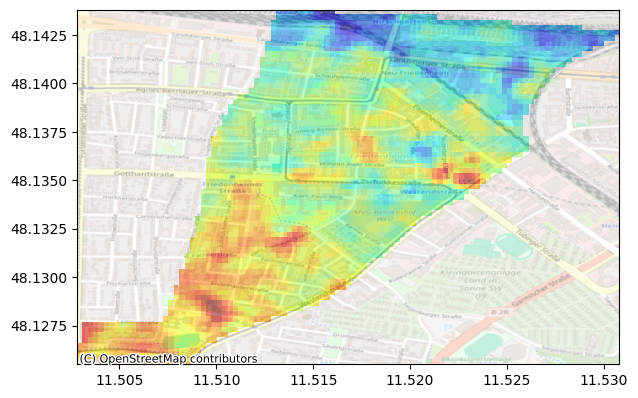

In [226]:
import rasterio
# from rasterio.plot import show  # Ensure show is imported
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim02.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)
    bounds = src.bounds

# Plot GeoTIFF
fig, ax = plt.subplots()
rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='jet')

# Add OSM tiles
ctx.add_basemap(ax=ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
# cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

plt.show()


In [53]:
import os    
from shapely import bounds

def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]

def query2osm(query, INPUT, filename = None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
    
    driver = gdal.GetDriverByName('GTiff')  # Get GDAL driver GeoTiff
    extent = shapely.bounds(INPUT).tolist()
    # Get dimensions
    nrows = numpy_array.shape[0]
    ncols = numpy_array.shape[1]
    nbands = len(numpy_array.shape)
    data_type = gdal.GDT_Float32
    # Create a temp grid
    #options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
    grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(numpy_array)

    # Lat/Lon WSG84 Spatial Reference System
    srs = osr.SpatialReference()
    srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))

    # Save the file
    file_name = str(filename)+'.tif'
    print(f'Generated GeoTIFF: {file_name}')
    driver.CreateCopy(file_name, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid            
    os.remove('grid_data')
    
#     tiff_file = str(filename)+'.tif'
    with rasterio.open(file_name) as src:
        data = src.read(1)
        bounds = src.bounds

    # Plot GeoTIFF
    fig, ax = plt.subplots()
    rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='jet')

    # Add OSM tiles
    ctx.add_basemap(ax=ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    # cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

    plt.show()


Trudering - Riem of Tudering-Riem


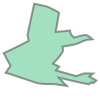

In [261]:
gid = 79
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [262]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'

79: Polygon is processing


Generated GeoTIFF: Untermenzing-Allach.tif


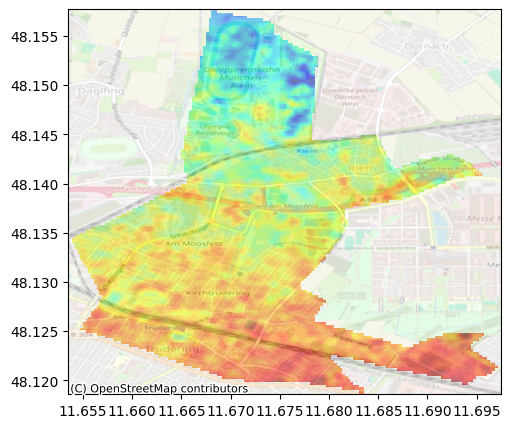

In [263]:
query2osm(qARRAY, INPUT, 'Untermenzing-Allach', -32768)

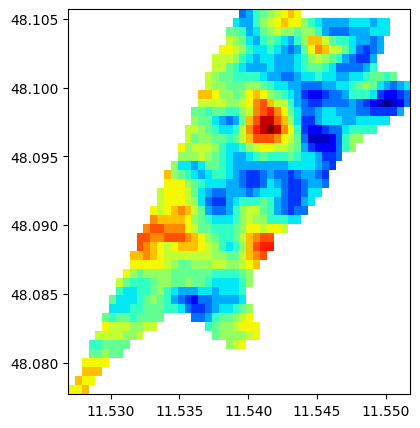

In [200]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim03.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)
    bounds = src.bounds  # Get bounds of the GeoTIFF

# Plot GeoTIFF
fig, ax = plt.subplots()
show(data, transform=src.transform, ax=ax, cmap='jet')  # Plot the GeoTIFF

# Set bounds to ensure proper alignment
ax.set_xlim(bounds.left, bounds.right)
ax.set_ylim(bounds.bottom, bounds.top)

# Add OSM basemap
# ctx.add_basemap(ax=ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


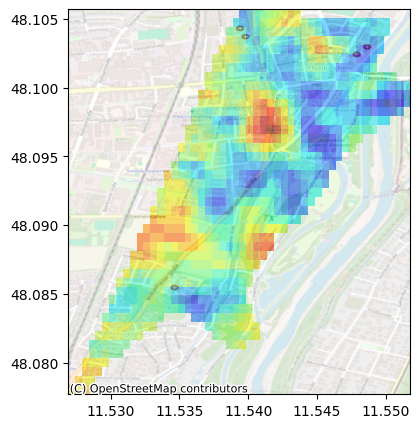

In [365]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim03.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)

# Plot GeoTIFF
fig, ax = plt.subplots()
show(data, transform=src.transform, ax=ax, cmap='jet')  # Plot the GeoTIFF

# Add OSM basemap with transparency
ctx.add_basemap(ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()


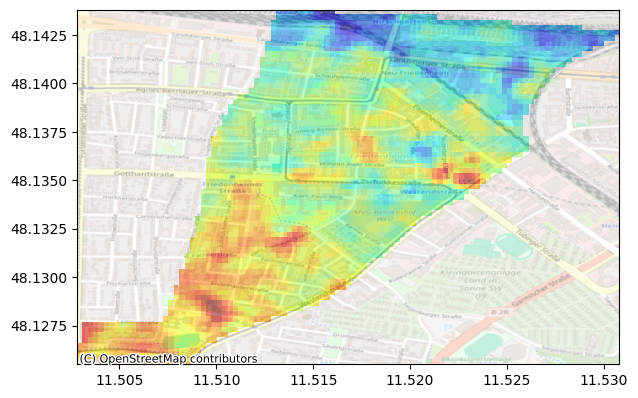

In [361]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim02.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)
    crs = src.crs  # Get CRS from GeoTIFF
    transform = src.transform  # Get transform

# Plot GeoTIFF
fig, ax = plt.subplots()
show(data, transform=transform, ax=ax, cmap='jet')  # Display GeoTIFF with jet colormap

# Add OSM tiles using the GeoTIFF's CRS
ctx.add_basemap(ax, crs=crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()


### STANDALONE

Untermenzing-Allach of Allach-Untermenzing
77: Polygon is processing
Generated GeoTIFF: OUTPUT.tif


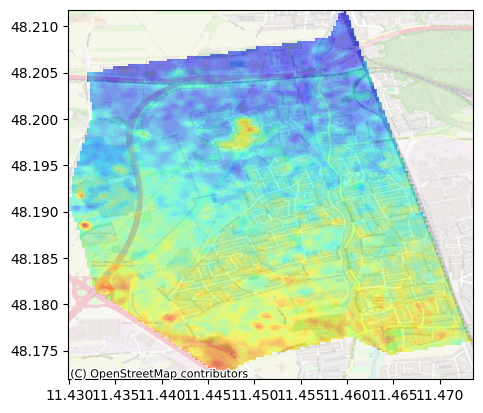

In [63]:
gid = 77
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2osm(qARRAY, INPUT, 'OUTPUT', -32768)

# query2folium ()

In [33]:
collection_list

['Munich_Temperature_MODIS_1km',
 'South_Tyrol_Temperature_MODIS_1km',
 'Bavaria_NDVI_250m',
 'LST_03_GeoTIFF_FLIPPED',
 'Munich_SRTM_NC_Elevation',
 'LST_03_GeoTIFF_FLIPPED_CRS',
 'Winter_in_sweden1',
 'Munich_MODIS_NDVI',
 'Bavaria_Temperature_MODIS_1km',
 'AIR_TEMP_X',
 'Surface_Temperature_Sweden']

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import rasterio
from rasterio.plot import show, reshape_as_image, reshape_as_raster, reshape_as_image
import folium
from folium.raster_layers import ImageOverlay

In [83]:
def get_polygon_extent(polygon):
    coords = list(polygon.exterior.coords)
    xs = [x for x, y in coords]
    ys = [y for x, y in coords]
    return [min(xs), min(ys), max(xs), max(ys)]

def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]

def query2folium(query, INPUT, filename = None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
    
    driver = gdal.GetDriverByName('GTiff')  # Get GDAL driver GeoTiff
    extent = shapely.bounds(INPUT).tolist()
    # Get dimensions
    nrows = numpy_array.shape[0]
    ncols = numpy_array.shape[1]
    nbands = len(numpy_array.shape)
    data_type = gdal.GDT_Float32
    # Create a temp grid
    #options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
    grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(numpy_array)

    # Lat/Lon WSG84 Spatial Reference System
    srs = osr.SpatialReference()
    srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))

    # Save the file
    file_name = str(filename)+'.tif'
    print(f'Generated GeoTIFF: {file_name}')
    driver.CreateCopy(file_name, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid            
    os.remove('grid_data')
    # Enter Folium
    elevRaster = rasterio.open(file_name)
    elevArray = elevRaster.read(1)

    boundList = [x for x in elevRaster.bounds]

    # Normalize the data for colormap application
    norm = Normalize(vmin=np.nanmin(elevArray), vmax=np.nanmax(elevArray))

    # Create a colormap (e.g., jet)
    cmap = plt.cm.get_cmap('jet')

    # Function to apply colormap
    def colormap_function(x):
        rgba = cmap(norm(x))  # Apply normalization and colormap
        return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

    rasLon = (boundList[3] + boundList[1])/2
    rasLat = (boundList[2] + boundList[0])/2
    mapCenter = [rasLon, rasLat]

    # Initialize the folium map
    mf = folium.Map(location=mapCenter, zoom_start=13)  # Change the center and zoom as needed

    # Add raster overlay with the colormap
    folium.raster_layers.ImageOverlay(
        image=elevArray,
        bounds=[[boundList[1], boundList[0]], [boundList[3], boundList[2]]],
        opacity=0.52,
        colormap=colormap_function,  # Apply the colormap function
        interactive=True,
        cross_origin=False,
    ).add_to(mf)
    
    print('\n',mf)
    
    return mf

In [84]:
# gid = 56
# print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
# INPUT = gdfSubDist105.geometry[gid]

# qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_MODIS_NDVI as m'
# query2folium(qARRAY, INPUT, 'NDVI', -3000)

In [98]:
gid = 56 # Total 105 subdistricts
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]

Biederstein of Schwabing-Freimann


In [99]:
qARRAY = 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'

56: Polygon is processing


In [100]:
qARRAY

'select clip(m[0, 0:* , 0:*],POLYGON ((315 834, 314 835, 309 838, 302 842, 302 842, 297 845, 283 853, 278 855, 278 855, 273 859, 274 875, 274 880, 278 878, 280 879, 281 883, 283 883, 284 881, 286 877, 289 873, 295 868, 297 864, 300 862, 302 860, 304 859, 306 860, 308 861, 309 861, 309 860, 310 859, 310 857, 306 851, 306 850, 306 848, 307 847, 310 842, 311 840, 314 837, 315 835, 315 834))) from Munich_SRTM_NC_Elevation as m'

Biederstein of Schwabing-Freimann
56: Polygon is processing
Generated GeoTIFF: OUTPUT.tif




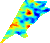

In [85]:
query2folium(qARRAY, INPUT, 'OUTPUT', -32768)

89: Polygon is processing
Generated GeoTIFF: OUTPUT - 89.tif




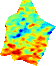

In [86]:
gid = np.random.randint(0, 100)
INPUT = gdfSubDist105.geometry[gid]
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2folium(qARRAY, INPUT, 'OUTPUT - '+str(gid), -32768)

In [94]:
# List of GeoTIFF file OUTPUT - 81.tif
geotiff_files = ["OUTPUT#3.tif", "OUTPUT#7.tif", "OUTPUT#40.tif", "OUTPUT#19.tif","OUTPUT#79.tif",
                 "OUTPUT#97.tif", "OUTPUT#51.tif", "OUTPUT#38.tif"]  # Replace with actual file paths

# Initialize the Folium map
m = folium.Map(location=[48.140127502683185, 11.564962856463069], zoom_start=12)  # Adjust location and zoom level as needed

# Create a colormap (e.g., jet)
cmap = plt.cm.get_cmap("jet")
# norm = Normalize(vmin=0, vmax=255)  # Adjust if needed

for geotiff in geotiff_files:
    # Open the GeoTIFF
    with rasterio.open(geotiff) as src:
        data = src.read(1)  # Read the first band
        bounds = src.bounds

        norm = Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))

        # Function to apply colormap
        def colormap_function(x):
            rgba = cmap(norm(x))  # Apply normalization and colormap
            return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

        # Convert bounds to lat/lon for overlay
        west, south, east, north = bounds
        folium.raster_layers.ImageOverlay(
            image=data,
            bounds=[[south, west], [north, east]],
            opacity=0.52,
            colormap=colormap_function,  # Apply the colormap function
            interactive=True,
            cross_origin=False,
        ).add_to(m)
        
m.save("OUTPUTMAP.html")
print(m)


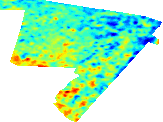
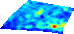
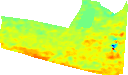
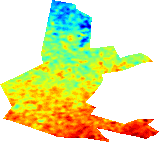
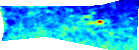
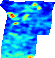
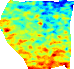

In [95]:
m

In [96]:
print(type(m)) # RDF Type for map object xsd:Map or xsd:Tiff ??

<class 'folium.folium.Map'>


In [97]:
print(type('<folium.folium.Map object at 0x7fda9e267df0>')) # Return Tyoe from DB and ONTOP

<class 'str'>


In [76]:
# gid = np.random.randint(0, 100)
# INPUT = gdfSubDist105.geometry[gid]
# extent = bounds(INPUT).tolist() #bounds(Polygon()).tolist()
# extent

In [77]:
# Biederstein
# extent = shapely.bounds(INPUT).tolist() #bounds(Polygon()).tolist()
# extent

In [78]:
# from shapely import bounds

# geomm = 'POLYGON ((11.5028 48.1255, 11.5308 48.1255, 11.5308 48.1438, 11.5028 48.1438, 11.5028 48.1255))'
# geomm = wkt.loads(geomm)
# extent = bounds(geomm).tolist()
# print(extent)

In [79]:
# geomm1 = 'POLYGON ((11.5028 48.1255, 11.5308 48.1255, 11.5308 48.1438, 11.5028 48.1438, 11.5028 48.1255))'
# geomm1 = wkt.loads(geomm1)
# extent = list(geomm1.bounds) 
# extent

In [891]:
x = 0
maps = []
while x < 2:
    gid = np.random.randint(0, 100)
    INPUT = gdfSubDist105.geometry[gid]
    qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
    k =query2folium(qARRAY, INPUT, 'OUTPUT#'+str(gid), -32768)
    maps.append(k)
    x += 1

55: Polygon is processing
Generated GeoTIFF: OUTPUT#55.tif
64: Polygon is processing
Generated GeoTIFF: OUTPUT#64.tif



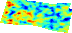


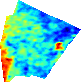

In [892]:
for map in maps:
    display(map)

In [897]:
print(maps[1])

In [896]:
print(type(maps[1]))

<class 'folium.folium.Map'>


In [908]:
print(type('<folium.folium.Map object at 0x7f504d584040>'))

<class 'str'>


In [429]:
# #from osgeo import gdal
# # import matplotlib.pyplot as plt
# # import numpy as np
# # import rasterio
# # import folium

# # representation of the generated raster
# elevRaster = rasterio.open('Friedenheim02.tif')
# elevArray = elevRaster.read(1)

# boundList = [x for x in elevRaster.bounds]

# #get rid of the nan for color interpretation
# elevArray = np.nan_to_num(elevArray)

# # plt.imshow(elevArray)


# rasLon = (boundList[3] + boundList[1])/2
# rasLat = (boundList[2] + boundList[0])/2
# mapCenter = [rasLon, rasLat]

# # Create a Folium map centered at a specific location
# m = folium.Map(location=mapCenter, zoom_start=14)

# # Add raster overlay
# image = folium.raster_layers.ImageOverlay(
#     image=elevArray,
#     bounds=[[boundList[1], boundList[0]], [boundList[3], boundList[2]]],
#     opacity=0.6,
#     colormap=plt.cm.get_cmap('jet'),
#     interactive=True,
#     cross_origin=False,
# )
# image.add_to(m)

# # Add layer control
# folium.LayerControl().add_to(m)

# # Display the map
# m


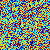

In [666]:
import folium
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Example: Create an array of elevation data
elevRaster = rasterio.open('Friedenheim02.tif')
# elevArray = elevRaster.read(1)

boundList = [x for x in elevRaster.bounds]
elevArray = np.random.randint(400, 550, size=(50, 50))  # Replace with your actual data
boundList = [-10, -10, 10, 10]  # Replace with the bounds of your image

# Normalize the data for colormap application
norm = Normalize(vmin=np.min(elevArray), vmax=np.max(elevArray))

# Create a colormap (e.g., jet)
cmap = plt.cm.get_cmap('jet')

# Function to apply colormap
def colormap_function(x):
    rgba = cmap(norm(x))  # Apply normalization and colormap
    return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

rasLon = (boundList[3] + boundList[1])/2
rasLat = (boundList[2] + boundList[0])/2
mapCenter = [rasLon, rasLat]

# Initialize the folium map
m = folium.Map(location=mapCenter, zoom_start=5)  # Change the center and zoom as needed

# Add raster overlay with the colormap
image = folium.raster_layers.ImageOverlay(
    image=elevArray,
    bounds=[[boundList[1], boundList[0]], [boundList[3], boundList[2]]],
    opacity=0.52,
    colormap=colormap_function,  # Apply the colormap function
    interactive=True,
    cross_origin=False,
)
image.add_to(m)

# Save map
m

In [414]:
np.max(elevArray)

549


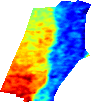

In [898]:
elevRaster = rasterio.open('Friedenheim04.tif')
elevArray = elevRaster.read(1)

boundList = [x for x in elevRaster.bounds]

# Normalize the data for colormap application
norm = Normalize(vmin=np.nanmin(elevArray), vmax=np.nanmax(elevArray))

# Create a colormap (e.g., jet)
cmap = plt.cm.get_cmap('jet')

# Function to apply colormap
def colormap_function(x):
    rgba = cmap(norm(x))  # Apply normalization and colormap
    return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

rasLon = (boundList[3] + boundList[1])/2
rasLat = (boundList[2] + boundList[0])/2
mapCenter = [rasLon, rasLat]

# Initialize the folium map
m = folium.Map(location=mapCenter, zoom_start=14)  # Change the center and zoom as needed

# Add raster overlay with the colormap
image = folium.raster_layers.ImageOverlay(
    image=elevArray,
    bounds=[[boundList[1], boundList[0]], [boundList[3], boundList[2]]],
    opacity=0.52,
    colormap=colormap_function,  # Apply the colormap function
    interactive=True,
    cross_origin=False,
)
image.add_to(m)

# Save map
m

In [422]:
np.nanmax(elevArray)

544.0


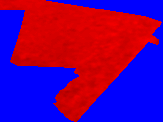
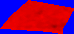
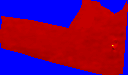

In [66]:
# import rasterio
# import numpy as np
# import folium
# from matplotlib.colors import Normalize
# from PIL import Image
# import matplotlib.pyplot as plt

# List of GeoTIFF file OUTPUT - 81.tif
geotiff_files = ["OUTPUT#3.tif", "OUTPUT#7.tif", "OUTPUT#40.tif", "OUTPUT#19.tif"]  # Replace with actual file paths

# Initialize the Folium map
m = folium.Map(location=[48.140127502683185, 11.564962856463069], zoom_start=12)  # Adjust location and zoom level as needed

# Create a colormap (e.g., jet)
cmap = plt.cm.get_cmap("jet")
norm = Normalize(vmin=0, vmax=255)  # Adjust if needed

for geotiff in geotiff_files:
    # Open the GeoTIFF
    with rasterio.open(geotiff) as src:
        data = src.read(1)  # Read the first band
        bounds = src.bounds

    # Normalize data to [0, 255]
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs/Infs
    data_min, data_max = np.nanmin(data), np.nanmax(data)
    if data_min == data_max:
        data_normalized = np.zeros_like(data)  # Handle constant data
    else:
        data_normalized = ((data - data_min) / (data_max - data_min) * 255).astype(np.uint8)

    # Apply the colormap to the data
    rgba_data = cmap(norm(data_normalized))  # Result is an RGBA array
    rgb_data = (rgba_data[:, :, :3] * 255).astype(np.uint8)  # Convert RGBA to RGB

    # Convert bounds to lat/lon for overlay
    west, south, east, north = bounds

    # Add raster overlay to the map
    folium.raster_layers.ImageOverlay(
        image=rgb_data,  # Use NumPy array directly
        bounds=[[south, west], [north, east]],
        opacity=0.6,  # Adjust transparency if needed
    ).add_to(m)

m

In [661]:
np.random.randint(0, 104)

45

In [68]:
# List of GeoTIFF file OUTPUT - 81.tif
geotiff_files = ["OUTPUT#3.tif", "OUTPUT#7.tif", "OUTPUT#40.tif", "OUTPUT#19.tif"]  # Replace with actual file paths

# Initialize the Folium map
m = folium.Map(location=[48.140127502683185, 11.564962856463069], zoom_start=12)  # Adjust location and zoom level as needed

# Create a colormap (e.g., jet)
cmap = plt.cm.get_cmap("jet")
# norm = Normalize(vmin=0, vmax=255)  # Adjust if needed

for geotiff in geotiff_files:
    # Open the GeoTIFF
    with rasterio.open(geotiff) as src:
        data = src.read(1)  # Read the first band
        bounds = src.bounds

        norm = Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))

        # Function to apply colormap
        def colormap_function(x):
            rgba = cmap(norm(x))  # Apply normalization and colormap
            return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

        # Convert bounds to lat/lon for overlay
        west, south, east, north = bounds
        folium.raster_layers.ImageOverlay(
            image=data,
            bounds=[[south, west], [north, east]],
            opacity=0.52,
            colormap=colormap_function,  # Apply the colormap function
            interactive=True,
            cross_origin=False,
        ).add_to(m)
        
m.save("OUTPUTMAP.html")


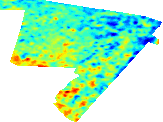
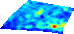
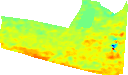

In [69]:
m

# query2covjson ()

- https://covjson.org/
- https://github.com/KNMI/covjson-pydantic
- https://github.com/Reading-eScience-Centre/pycovjson/tree/master

In [798]:
pip install pycovjson

Exception ignored in: <function _after_fork at 0x7f53da8fa700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
    thread._stop()
TypeError: 'Event' object is not callable


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for pycovjson: filename=pycovjson-0.3.9-py3-none-any.whl size=13597 sha256=22276c5748b36eee7ef9ed66dd8fc235e396f7ace1c7a3496eba99446be5b33a
  Stored in directory: /home/arkaghosh/.cache/pip/wheels/34/95/21/9620358f876db561c722159202ec9bb4769d7cf2dad5594597
Successfully built pycovjson
Note: you may need to restart the kernel to use updated packages.


In [827]:
import pycovjson
from pycovjson import read_netcdf, convert

In [828]:
mydata = pycovjson.read_netcdf.NetCDFReader(raster01_path)
mydata

In [829]:
print(mydata)

In [844]:
# pycovjson.convert('polcoms.nc', 'coverage.covjson', [sst])
pycovjson.convert(raster01_path, 'mydata.covjson', ['SRTMGL1_DEM'])

TypeError: 'module' object is not callable

In [845]:
pip install covjson-pydantic

Exception ignored in: <function _after_fork at 0x7f53da8fa700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
    thread._stop()
TypeError: 'Event' object is not callable


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [848]:
from datetime import datetime, timezone
from pydantic import AwareDatetime
from covjson_pydantic.coverage import Coverage
from covjson_pydantic.domain import Domain, Axes, ValuesAxis, DomainType
from covjson_pydantic.ndarray import NdArrayFloat

c = Coverage(
    domain=Domain(
        domainType=DomainType.point_series,
        axes=Axes(
            x=ValuesAxis[float](values=[1.23]),
            y=ValuesAxis[float](values=[4.56]),
            t=ValuesAxis[AwareDatetime](values=[datetime(2024, 8, 1, tzinfo=timezone.utc)]),
        ),
    ),
    ranges={
        "temperature": NdArrayFloat(axisNames=["x", "y", "t"], shape=[1, 1, 1], values=[42.0])
    }
)

print(c.model_dump_json(exclude_none=True, indent=4))

{
    "type": "Coverage",
    "domain": {
        "type": "Domain",
        "domainType": "PointSeries",
        "axes": {
            "x": {
                "values": [
                    1.23
                ]
            },
            "y": {
                "values": [
                    4.56
                ]
            },
            "t": {
                "values": [
                    "2024-08-01T00:00:00Z"
                ]
            }
        }
    },
    "ranges": {
        "temperature": {
            "type": "NdArray",
            "dataType": "float",
            "axisNames": [
                "x",
                "y",
                "t"
            ],
            "shape": [
                1,
                1,
                1
            ],
            "values": [
                42.0
            ]
        }
    }
}


In [873]:
# from datetime import datetime, timezone
from typing import List, Optional

# Assuming appropriate classes and imports similar to your original example
d = Coverage(
    domain=Domain(
        domainType=DomainType.grid,
        axes=Axes(
            x=ValuesAxis[float](values=[-10, -5, 0]),
            y=ValuesAxis[float](values=[40, 50]),
            z=ValuesAxis[float](values=[5]),
            t=ValuesAxis[AwareDatetime](values=[datetime(2010, 1, 1, 0, 12, 20, tzinfo=timezone.utc)]),
        ),
        referencing=[
            {
                "coordinates": ["y", "x", "z"],
                "system": {
                    "type": "GeographicCRS",
                    "id": "http://www.opengis.net/def/crs/EPSG/0/4979",
                },
            },
            {
                "coordinates": ["t"],
                "system": {
                    "type": "TemporalRS",
                    "calendar": "Gregorian",
                },
            },
        ],
    ),
    parameters={}, # stupid
    ranges={
        "ICEC": NdArrayFloat(
            axisNames=["t", "z", "y", "x"],
            shape=[1, 1, 2, 3],
            values=[0.5, 0.6, 0.4, 0.6, 0.2, None],
        )
    },
)

print(d.model_dump_json(exclude_none=True, indent=2))


{
  "type": "Coverage",
  "domain": {
    "type": "Domain",
    "domainType": "Grid",
    "axes": {
      "x": {
        "values": [
          -10.0,
          -5.0,
          0.0
        ]
      },
      "y": {
        "values": [
          40.0,
          50.0
        ]
      },
      "z": {
        "values": [
          5.0
        ]
      },
      "t": {
        "values": [
          "2010-01-01T00:12:20Z"
        ]
      }
    },
    "referencing": [
      {
        "coordinates": [
          "y",
          "x",
          "z"
        ],
        "system": {
          "type": "GeographicCRS",
          "id": "http://www.opengis.net/def/crs/EPSG/0/4979"
        }
      },
      {
        "coordinates": [
          "t"
        ],
        "system": {
          "type": "TemporalRS",
          "calendar": "Gregorian"
        }
      }
    ]
  },
  "parameters": {},
  "ranges": {
    "ICEC": {
      "type": "NdArray",
      "dataType": "float",
      "axisNames": [
        "t",
        "z